In [11]:
import numpy as np 
import random
import bisect
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import math

In [2]:
def readJSSP(path):
    with open(path, 'r') as f:
        lines =  f.readlines()
        jobs = [[(int(machine), int(cost)) for machine, cost in zip(line.split()[0::2], line.split()[1::2])]
                for line in lines[1:] if line.strip()]
        
        return jobs

In [109]:
def calcMakespan(jobs, schedule):
    n = len(jobs)
    m = len(jobs[0])
    
    job_end = np.zeros(n, dtype=np.int) # end of prev. tasks for each job 
    machine_end = np.zeros(m, dtype=np.int) # end of prev. task for each machine
    next_task = np.zeros(n, dtype=np.int) # next task for each job
    
    
    for job in schedule:
        machine, cost = jobs[job][next_task[job]]
        
        job_start = max(machine_end[machine], job_end[job])
        
        job_end[job] = job_start + cost
        machine_end[machine] = job_start + cost
        
        next_task[job] += 1
        
    return max(machine_end)

In [4]:
def convert_tour_to_schedule(m, tour):
    return list(map(lambda x: x // m, tour))

In [403]:
def calcProb(curr_node, av_nodes, op_counter, pheromones, aplha, beta):
    p = [(pheromones[curr_node][i] ** alp * ((1 / av_nodes[i][0]) ** beta), av_nodes[i][1]) for i in range(len(av_nodes))]
    s = sum([x[0] for x in p])
    p = [(p[i][0] / s, p[i][1]) for i in range(len(p))]
    return p

In [404]:
def stateTransition(tour, jobs, machines, op_counter, job_op_comp, pheromones, alpha, beta, q0):
    n, m = len(jobs), len(jobs[0])
    
    av_nodes = []
    for i in range(n):
        if(op_counter[i] < m):
            av_nodes.append((max(machines[jobs[i][op_counter[i]][0]], job_op_comp[i]) + jobs[i][op_counter[i]][1], i)) # complition time
    curr_node = tour[-1] if len(tour) != 0 else 0
    #print(len(pheromones))
    p = calcProb(curr_node, av_nodes, op_counter, pheromones, alpha, beta)
    #print("av: ", av_nodes)
    #print("p: ", p)
    #print("op_count: ", op_counter)
    s = int(p[0][1])
    q = random.random()
    if(q < q0):
        p_max = 0
        p_i = 0
        for x, i in p:
            
            if(x > p_max):
                p_max = x
                p_i = i    
        s = p_i
        #print("M")
    else: 
        
        prob_cumm = 0
        q = random.random()
        #print("r", q)
        for x, i in p:
            
            prob_cumm += x
            #print("x, i: ", prob_cumm, i)
            if(q < prob_cumm):
                s = i
                break
        
    s = min(s, n-1)
    return s

In [405]:
def antTour(jobs, pheromones, alp, beta, q0):
    n, m = len(jobs), len(jobs[0])
    tour = []
    machines = [0 for i in range(m)]
    op_counter = [0 for i in range(n)]
    job_op_comp = [0 for i in range(n)]
    for i in range(n * m):
        #print(len(pheromnoes))
        s = stateTransition(tour, jobs, machines, op_counter, job_op_comp, pheromones, alp, beta, q0)
        #print("choise: ", s)
        tour.append(s)
        machines[jobs[s][op_counter[s]][0]] += jobs[s][op_counter[s]][1] # update job complition time
        job_op_comp[s] += jobs[s][op_counter[s]][1]
        op_counter[s] += 1
    makespan = calcMakespan(jobs, tour)
    return tour, makespan

In [406]:
def antColony(jobs, l, pheromones, alp, beta, q0):
    colony_tour = []
    colony_makespan = []
    for _ in range(l):
        #print(len(pheromones))
        ant_tour, ant_makespan = antTour(jobs, pheromones, alp, beta, q0)
        colony_makespan.append(ant_makespan)
        colony_tour.append(ant_tour)
    return colony_tour, colony_makespan

In [407]:
def globalPheromoneUpdate(pheromones, best_tour, best_makespan, rho):
    for i in range(len(pheromnoes)):
        for j in range(len(pheromnoes[i])):
            pheromones[i][j] *= (1 - rho) # evaporation
            
    pheromones[0][best_tour[0]] += rho / best_makespan
    for i in range(1, len(best_tour)):
        pheromones[best_tour[i-1]][best_tour[i]] += rho / best_makespan
    return pheromones

In [416]:
def optimize(jobs, l, num_iter, alp, beta, q0, rho):
    n, m = len(jobs), len(jobs[0])
    best_global_makespan = 99999999
    best_tour = []
    history = []

    
    pheromones = []
    for i in range(n):
        tau_0 = [0 for _ in range(m)]
        for j in range(m):
            tau_0[j] = 1 / (n * (abs(sum(jobs[i][:][1]) - math.sqrt(jobs[i][1][1])))) # Initial Pheromones
        pheromones.append(tau_0)

    for it in tqdm(range(num_iter)):
        colony_tour, colony_makespan = antColony(jobs, l, pheromones, alp, beta, q0)
        
        best_colony_makespan = min(colony_makespan)
        if(best_colony_makespan < best_global_makespan):
            best_global_makespan = best_colony_makespan
            best_tour = colony_tour[colony_makespan.index(best_colony_makespan)]
            
        pheromones = globalPheromoneUpdate(pheromones, best_tour, best_global_makespan, rho)
        
        history.append({
            "it": it,
            "best_makespan": best_colony_makespan
        })
    return best_global_makespan, best_tour, history

In [451]:
jobs = readJSSP("./instanses/la16")
n, m = len(jobs), len(jobs[0])
alp = 0.1
beta = 2
q0 = 0.8
rho = 0.01
l = 20
num_iter = 1000

best_makespan, best_tour, history = optimize(jobs, l, num_iter, alp, beta, q0, rho)

print("best makespan: ", best_makespan)
print("best tour: ", best_tour)

/Users/yra/miniconda3/envs/jssp_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



best makespan:  1129
best tour:  [6, 0, 8, 5, 2, 7, 9, 8, 1, 0, 1, 0, 5, 7, 8, 7, 5, 5, 9, 3, 6, 6, 8, 1, 0, 7, 0, 2, 8, 5, 5, 8, 8, 7, 2, 2, 3, 1, 0, 4, 4, 4, 4, 6, 8, 6, 0, 7, 2, 1, 2, 4, 0, 0, 7, 7, 6, 2, 5, 5, 1, 4, 6, 9, 5, 9, 9, 1, 8, 6, 0, 3, 3, 3, 6, 9, 2, 5, 1, 6, 3, 3, 9, 4, 8, 9, 4, 4, 7, 7, 2, 9, 2, 4, 1, 1, 3, 3, 3, 9]


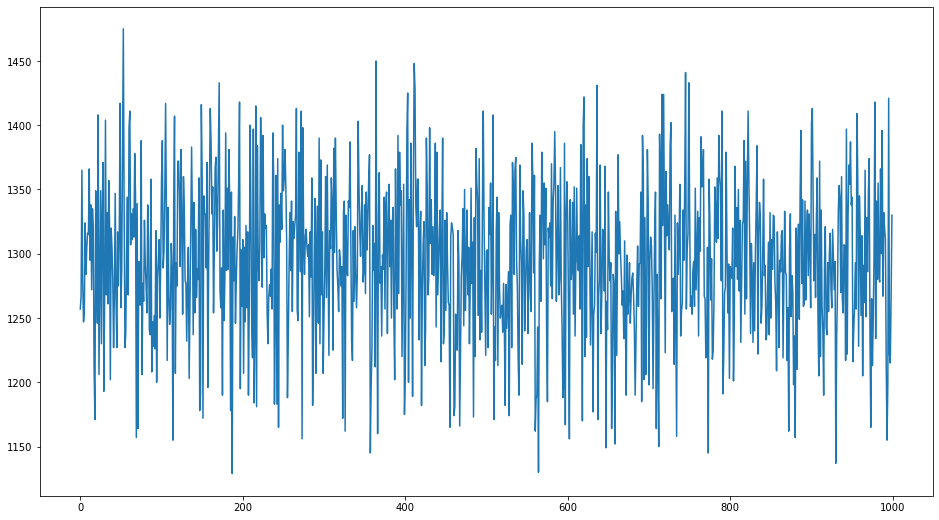

In [452]:
x = [it["it"] for it in history]
y = [it["best_makespan"] for it in history]
plt.figure(figsize=(16, 9))
plt.plot(x, y)

In [454]:
for i in range(10):
    col = 0 
    for s in best_tour:
        if s == i:
            col += 1
    print(i, col)

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
